# Data preprocessing (split to new Notebook later)

In [1]:
import dask.dataframe as dd
from dask.distributed import Client
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:33257 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 24 Memory: 33.64 GB


In [2]:
no_curves_dfs = []
for f in ['A', 'B', 'C']:
    df = dd.read_parquet(f + '.parquet', engine='pyarrow')  # Just to get columns
    df = dd.read_parquet(f + '.parquet', engine='pyarrow', columns=[col for col in df.columns if col not in ['time', 'y_diff', 'emf']]).drop_duplicates()
    df['input_excitation'] = df['input_excitation'].astype('int')
    df['device_id'] = f.split('.')[0]
    no_curves_dfs.append(df)
    
dd.concat(no_curves_dfs).to_parquet('no_curves.parquet', engine='pyarrow', compression='snappy')

In [102]:
client.close()

---

In [4]:
from dask.distributed import Client
import dask.dataframe as dd

client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:37575 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 24 Memory: 33.64 GB


In [5]:
root_path = './'
files_prefix = ['A', 'B', 'C']

In [6]:
dfs = []
for f in files_prefix:
    df = dd.read_parquet(root_path + f + '.parquet', engine='pyarrow')
    df['device_id'] = f
    df['input_excitation'] = df['input_excitation'].astype('int')
    dfs.append(df)
len(dfs)

3

In [7]:
dd.concat(dfs).to_parquet(root_path + 'joined.parquet', engine='pyarrow', partition_on=['device_id', 'input_excitation'], compression='brotli')

In [8]:
client.close()

## Start here

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [104]:
df2 = pd.read_parquet('no_curves.parquet').reset_index(drop=True)
df2.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_model.coil_resistance,load_model.R,input_excitation,device_id
0,0.0,2040,10.311698,-28.904115,59.527673,13.964286,0.000000,6.666667,12.5,30,0,A
1,1.0,2041,10.576553,-27.212625,56.860256,13.964286,0.714286,6.666667,12.5,30,0,A
2,2.0,2042,10.880574,-25.251209,58.145960,13.964286,1.428571,6.666667,12.5,30,0,A
3,3.0,2043,11.180500,-23.143741,69.403233,13.964286,2.142857,6.666667,12.5,30,0,A
4,4.0,2044,11.496135,-20.914808,68.668414,13.964286,2.857143,6.666667,12.5,30,0,A


In [105]:
df2_filtered = df2

In [106]:
# Some feature engineering, where we calcute all our objective functions
# TODO: Write these as functions
df2_filtered.loc[:, 'rms_perc_abs'] = np.abs(df2_filtered['rms_perc_diff'])
df2_filtered['dtw_mech'] = df2_filtered['y_diff_dtw_distance']
df2_filtered['dtw_mech_norm'] = (df2_filtered['dtw_mech'] - df2_filtered['dtw_mech'].min())/(df2_filtered['dtw_mech'].max() - df2_filtered['dtw_mech'].min())
df2_filtered['dtw_elec'] = df2_filtered['emf_dtw_distance']
df2_filtered['dtw_elec_norm'] = (df2_filtered['dtw_elec'] - df2_filtered['dtw_elec'].min())/(df2_filtered['dtw_elec'].max() - df2_filtered['dtw_elec'].min())
df2_filtered['dtw_both'] = df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['rms_perc_abs_norm'] = (df2_filtered['rms_perc_abs'] - df2_filtered['rms_perc_abs'].min())/(df2_filtered['rms_perc_abs'].max() - df2_filtered['rms_perc_abs'].min())
df2_filtered['rms_dtw_elec'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_elec_norm']
df2_filtered['balanced'] = df2_filtered['rms_perc_abs_norm'] + df2_filtered['dtw_mech_norm'] + df2_filtered['dtw_elec_norm']

In [107]:
df2_filtered = df2_filtered.reset_index(drop=True)
df2_filtered.head()

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_model.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
0,0.0,2040,10.311698,-28.904115,59.527673,13.964286,0.000000,6.666667,12.5,30,...,A,28.904115,10.311698,0.092609,59.527673,0.012750,0.105359,0.047364,0.060114,0.152723
1,1.0,2041,10.576553,-27.212625,56.860256,13.964286,0.714286,6.666667,12.5,30,...,A,27.212625,10.576553,0.095817,56.860256,0.011256,0.107072,0.044592,0.055848,0.151664
2,2.0,2042,10.880574,-25.251209,58.145960,13.964286,1.428571,6.666667,12.5,30,...,A,25.251209,10.880574,0.099499,58.145960,0.011976,0.111475,0.041378,0.053354,0.152852
3,3.0,2043,11.180500,-23.143741,69.403233,13.964286,2.142857,6.666667,12.5,30,...,A,23.143741,11.180500,0.103131,69.403233,0.018281,0.121412,0.037924,0.056205,0.159336
4,4.0,2044,11.496135,-20.914808,68.668414,13.964286,2.857143,6.666667,12.5,30,...,A,20.914808,11.496135,0.106954,68.668414,0.017869,0.124823,0.034271,0.052140,0.159094


In [108]:
# Remove model ids that perform really poorly
# We do this so that we don't skew results by severe outliers that occur due to buggy simulations
criteria = 'rms_perc_diff'
percent_samples = 0.9745  # Outside of 3 standard deviations
cut_off = (1-percent_samples)/2
upper_bound = df2_filtered[criteria].quantile(percent_samples)
lower_bound = df2_filtered[criteria].quantile(1-(percent_samples + cut_off))
print(lower_bound, upper_bound)

to_drop_lower = df2_filtered.query(f'{criteria} < {lower_bound}')['model_id'].values
to_drop_upper = df2_filtered.query(f'{criteria} > {upper_bound}')['model_id'].values

to_drop = np.concatenate([to_drop_lower, to_drop_upper])

df2_filtered = df2_filtered[~df2_filtered['model_id'].isin(to_drop)]

-47.11100738156361 193.79824338208957


In [109]:
len(df2_filtered)

32252

In [110]:
df2_filtered.sort_values(by='rms_perc_diff', ascending=False)

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_model.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
207,15.0,327,28.875421,193.385130,254.209562,2.571429,8.571429,1.111111,12.5,30,...,A,193.385130,28.875421,0.317435,254.209562,0.121782,0.439216,0.316909,0.438691,0.756125
1973,11.0,275,32.021886,193.167661,287.016965,1.535714,3.571429,8.888889,12.5,30,...,A,193.167661,32.021886,0.355542,287.016965,0.140155,0.495697,0.316553,0.456708,0.812250
1094,20.0,212,28.355968,192.762714,278.991471,1.535714,1.428571,4.444444,12.5,30,...,A,192.762714,28.355968,0.311144,278.991471,0.135661,0.446804,0.315889,0.451550,0.762694
1896,6.0,342,28.926721,192.403314,264.540449,2.571429,8.571429,2.222222,12.5,30,...,A,192.403314,28.926721,0.318056,264.540449,0.127567,0.445623,0.315300,0.442868,0.760924
1254,12.0,228,29.166831,192.369933,280.716964,1.535714,2.142857,5.555556,12.5,30,...,A,192.369933,29.166831,0.320964,280.716964,0.136627,0.457591,0.315246,0.451873,0.772837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10222,22.0,1246,20.084398,-47.070862,103.154459,8.785714,0.714286,3.333333,12.5,30,...,A,47.070862,20.084398,0.210966,103.154459,0.037183,0.248149,0.077135,0.114318,0.325284
9973,13.0,1261,20.084089,-47.081048,103.059890,8.785714,0.714286,4.444444,12.5,30,...,A,47.081048,20.084089,0.210963,103.059890,0.037130,0.248093,0.077152,0.114282,0.325244
9580,4.0,1276,20.080482,-47.084932,103.077000,8.785714,0.714286,5.555556,12.5,30,...,A,47.084932,20.080482,0.210919,103.077000,0.037140,0.248059,0.077158,0.114298,0.325217
9595,19.0,1291,20.075659,-47.099294,103.071656,8.785714,0.714286,6.666667,12.5,30,...,A,47.099294,20.075659,0.210861,103.071656,0.037137,0.247997,0.077182,0.114318,0.325179


In [111]:
print(len(df2))
len(df2_filtered)

49500


32252

In [112]:
df2_filtered.query('device_id == "A"').groupby(['input_excitation']).agg({'balanced': 'mean', 'y_diff_dtw_distance': 'mean'}).style.background_gradient(cmap='Reds')

,balanced,y_diff_dtw_distance
input_excitation,,
0,0.304794,15.623396
1,0.243194,14.811184
2,0.256751,16.231341
3,0.265216,14.929108
4,0.292055,18.163126
5,0.251534,16.146709
6,0.242562,14.818228


In [113]:
def which_inputs_to_drop(df, device, number_to_drop):
    return (
        df
        .query(f'device_id == "{device}"')
        .groupby(['device_id', 'input_excitation'])
        .agg({'y_diff_dtw_distance': 'mean'})
        .sort_values(by='y_diff_dtw_distance', ascending=False)
        .reset_index()
        .iloc[:number_to_drop, :]['input_excitation']
        .values
    )

In [114]:
indexes_to_drop = []
for device, num in zip(['A', 'B', 'C'], [2, 2, 3]):
    to_drop = which_inputs_to_drop(df2_filtered, device, num)
    print(to_drop)
    x = df2_filtered[df2_filtered['input_excitation'].isin(to_drop)]
    x = x[x['device_id'] == device]
    indexes_to_drop.append(x.index)

[4 2]
[2 6]
[2 6 7]


In [115]:
indexes_to_drop

[Int64Index([ 4501,  4502,  4503,  4504,  4505,  4516,  4517,  4518,  4519,
              4520,
             ...
             11240, 11241, 11242, 11243, 11244, 11245, 11246, 11247, 11248,
             11249],
            dtype='int64', length=2932),
 Int64Index([20250, 20251, 20252, 20253, 20254, 20255, 20256, 20257, 20258,
             20259,
             ...
             31489, 31490, 31491, 31492, 31493, 31495, 31496, 31497, 31498,
             31499],
            dtype='int64', length=2932),
 Int64Index([36010, 36011, 36012, 36013, 36014, 36024, 36025, 36026, 36027,
             36028,
             ...
             49490, 49491, 49492, 49493, 49494, 49495, 49496, 49497, 49498,
             49499],
            dtype='int64', length=4398)]

In [116]:
len(df2_filtered)

32252

In [117]:
for idx in indexes_to_drop:
    df2_filtered = df2_filtered.drop(idx)

In [118]:
len(df2_filtered)

21990

In [119]:
df_scores = df2_filtered.groupby(['model_id']).agg({
    'dtw_mech': 'mean',
    'dtw_elec': 'mean',
    'dtw_both': 'mean',
    'rms_perc_abs': 'mean',
    'rms_dtw_elec': 'mean',
    'balanced': 'mean'
})
df_scores.head()

,dtw_mech,dtw_elec,dtw_both,rms_perc_abs,rms_dtw_elec,balanced
model_id,,,,,,
211,24.328012,223.499462,0.366943,65.304595,0.211598,0.473959
212,23.578083,236.281496,0.365019,72.153398,0.229980,0.483259
225,24.021389,218.503657,0.360432,64.557098,0.207575,0.466223
226,22.698665,224.573059,0.347811,64.172321,0.210344,0.452972
227,24.186008,237.812691,0.373240,71.877661,0.230386,0.491027


In [120]:
# Let's get the best performing model ids for each objective_function
best_model_ids = {}
for obj_func in df_scores.columns:
    best_model_id = df_scores.sort_values(by=obj_func).index[0]
    best_model_ids[obj_func] = best_model_id
    
best_model_ids

{'dtw_mech': 934,
 'dtw_elec': 1434,
 'dtw_both': 1086,
 'rms_perc_abs': 1340,
 'rms_dtw_elec': 1297,
 'balanced': 1342}

In [121]:
best_param_sets = [v for v in best_model_ids.values()]

In [122]:
df2_filtered.query('model_id == 1297')

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_model.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
121,1.0,1297,10.832934,4.104655,56.250010,8.785714,5.0,6.666667,12.5,30,...,A,4.104655,10.832934,0.098922,56.250010,0.010914,0.109836,0.006724,0.017638,0.116559
4069,1.0,1297,9.512242,9.167320,72.399806,8.785714,5.0,6.666667,12.5,30,...,A,9.167320,9.512242,0.082927,72.399806,0.019959,0.102885,0.015020,0.034979,0.117906
8353,1.0,1297,9.798234,17.413037,60.798094,8.785714,5.0,6.666667,12.5,30,...,A,17.413037,9.798234,0.086390,60.798094,0.013461,0.099852,0.028533,0.041994,0.128384
12019,1.0,1297,11.584524,-3.068829,67.426707,8.785714,5.0,6.666667,12.5,30,...,A,3.068829,11.584524,0.108024,67.426707,0.017174,0.125198,0.005026,0.022200,0.130224
14221,1.0,1297,11.806688,3.362896,72.294763,8.785714,5.0,6.666667,12.5,30,...,A,3.362896,11.806688,0.110715,72.294763,0.019900,0.130615,0.005508,0.025408,0.136123
17353,1.0,1297,8.341974,16.599497,94.794010,8.785714,5.0,6.666667,23.5,30,...,B,16.599497,8.341974,0.068753,94.794010,0.032501,0.101254,0.027200,0.059700,0.128454
19297,1.0,1297,5.250346,-1.121499,63.859601,8.785714,5.0,6.666667,23.5,30,...,B,1.121499,5.250346,0.031311,63.859601,0.015176,0.046487,0.001835,0.017011,0.048321
22669,1.0,1297,8.893702,29.617038,73.102348,8.785714,5.0,6.666667,23.5,30,...,B,29.617038,8.893702,0.075435,73.102348,0.020352,0.095788,0.048532,0.068885,0.144320
26977,1.0,1297,6.856887,8.434057,90.722218,8.785714,5.0,6.666667,23.5,30,...,B,8.434057,6.856887,0.050768,90.722218,0.030220,0.080988,0.013818,0.044039,0.094806
27025,1.0,1297,5.444350,-1.115070,109.415343,8.785714,5.0,6.666667,23.5,30,...,B,1.115070,5.444350,0.033660,109.415343,0.040689,0.074350,0.001824,0.042514,0.076174


In [123]:
letters = [r'$A$', r'$B$', r'$C$', r'$D$', r'$E$', r'$F$', 'G']
letter_index = 0
seen_model_ids = []
model_id_to_letter_mapping = {}

for k, v in best_model_ids.items():
    if v not in model_id_to_letter_mapping.keys():
        model_id_to_letter_mapping[v] = letters[letter_index]
        letter_index += 1

In [124]:
model_id_to_letter_mapping 

{934: '$A$', 1434: '$B$', 1086: '$C$', 1340: '$D$', 1297: '$E$', 1342: '$F$'}

In [125]:
# Just to check
for k, v in best_model_ids.items():
    print(k, model_id_to_letter_mapping[v])

dtw_mech $A$
dtw_elec $B$
dtw_both $C$
rms_perc_abs $D$
rms_dtw_elec $E$
balanced $F$


In [126]:
df_filtered_scores = df2_filtered[df2_filtered.model_id.isin(best_param_sets)]
df_filtered_scores['metric_name'] = df_filtered_scores['model_id'].apply(lambda x: model_id_to_letter_mapping[x])
df_filtered_scores.head()

df_filtered_scores.columns = [col.replace('_', '.') for col in df_filtered_scores.columns]  # To not have latex rendering complain
df_filtered_scores.head()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,grid.cell.id,model.id,y.diff.dtw.distance,rms.perc.diff,emf.dtw.distance,damper.damping.coefficient,coupling.model.coupling.constant,mechanical.spring.damping.coefficient,coil.model.coil.resistance,load.model.R,...,rms.perc.abs,dtw.mech,dtw.mech.norm,dtw.elec,dtw.elec.norm,dtw.both,rms.perc.abs.norm,rms.dtw.elec,balanced,metric.name
121,1.0,1297,10.832934,4.104655,56.250010,8.785714,5.000000,6.666667,12.5,30,...,4.104655,10.832934,0.098922,56.250010,0.010914,0.109836,0.006724,0.017638,0.116559,$E$
396,18.0,1434,11.916379,3.151445,76.851700,9.821429,6.428571,5.555556,12.5,30,...,3.151445,11.916379,0.112043,76.851700,0.022452,0.134495,0.005161,0.027614,0.139657,$B$
864,6.0,1086,12.965645,7.110832,55.122238,7.750000,4.285714,2.222222,12.5,30,...,7.110832,12.965645,0.124751,55.122238,0.010283,0.135033,0.011650,0.021932,0.146683,$C$
1238,20.0,1340,10.155120,-0.189421,59.416392,8.785714,3.571429,10.000000,12.5,30,...,0.189421,10.155120,0.090713,59.416392,0.012687,0.103400,0.000307,0.012995,0.103707,$D$
1240,22.0,1342,10.843692,4.036338,56.299101,8.785714,5.000000,10.000000,12.5,30,...,4.036338,10.843692,0.099052,56.299101,0.010942,0.109994,0.006612,0.017553,0.116605,$F$


In [127]:
df_filtered_scores_melt = df_filtered_scores.melt(id_vars=['model.id', 'metric.name'], value_vars=['rms.perc.diff', 'dtw.mech', 'dtw.elec'])
df_filtered_scores_melt.head()

,model.id,metric.name,variable,value
0,1297,$E$,rms.perc.diff,4.104655
1,1434,$B$,rms.perc.diff,3.151445
2,1086,$C$,rms.perc.diff,7.110832
3,1340,$D$,rms.perc.diff,-0.189421
4,1342,$F$,rms.perc.diff,4.036338


In [128]:
def phd_theme():
    return theme(
        axis_line=element_line(color='black', size=0.5),
        axis_ticks=element_line(size=0.5),
        axis_title_x=element_text(size=16, margin={'t': 12}),
        axis_title_y=element_text(size=16),
        strip_text=element_text(size=16),
        axis_text=element_text(size=12),
        panel_background=element_blank(),
        panel_border=element_blank(),
        panel_grid=element_blank(),
        legend_key=element_blank(),
        legend_title=element_blank(),
        legend_background=element_blank(),
        legend_position=(0.8, 0.8),
        legend_direction='vertical',
    )

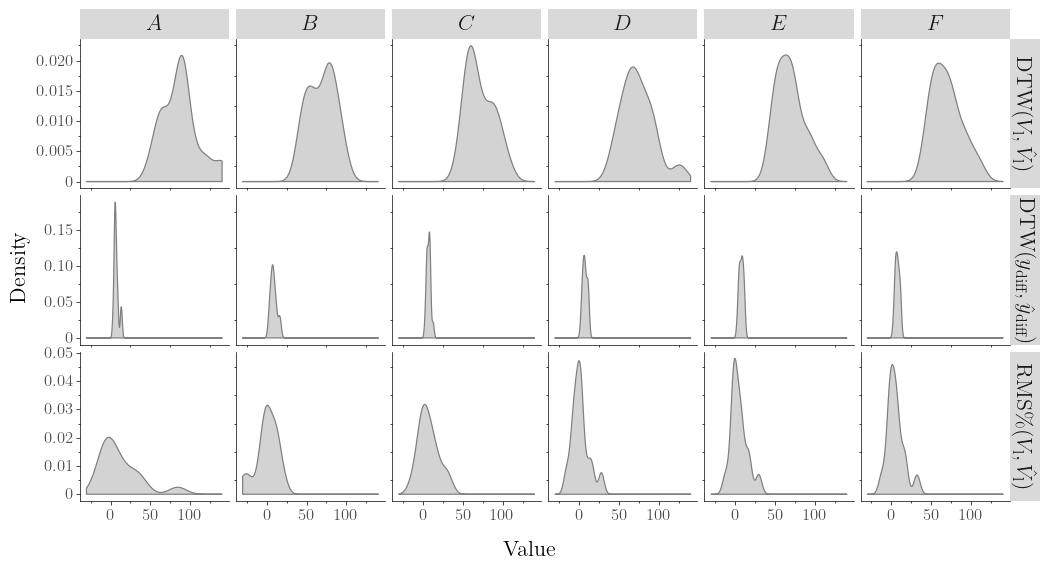

<ggplot: (8755178113809)>

In [129]:
from plotnine import *
from matplotlib import rc
rc('font', family='serif')
rc('text.latex', preamble=r'\usepackage{amsmath}')
rc('text', usetex=True)

cols_rename = {'dtw.elec': r'$\text{DTW}(V_{\text{l}}, \hat{V}_{\text{l}})$',
               'dtw.mech': r'$\text{DTW}(y_{\text{diff}},  \hat{y}_{\text{diff}})$',
               'rms.perc.diff': r'$\text{RMS\%}(V_{\text{l}}, \hat{V}_{\text{l}})$'}

lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='value'), df_filtered_scores_melt)
p = (
    p
    + geom_density(fill='lightgrey', color='grey') 
    + facet_grid('variable ~ metric.name', scales='free_y', labeller=lblr) 
    + xlab('Value')
    + ylab('Density')
    + theme(figure_size=(12, 6)) 
    + phd_theme()
)
#p.save('/home/michael/Nextcloud/nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 4 x 8 in image.
/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/michael/Nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf


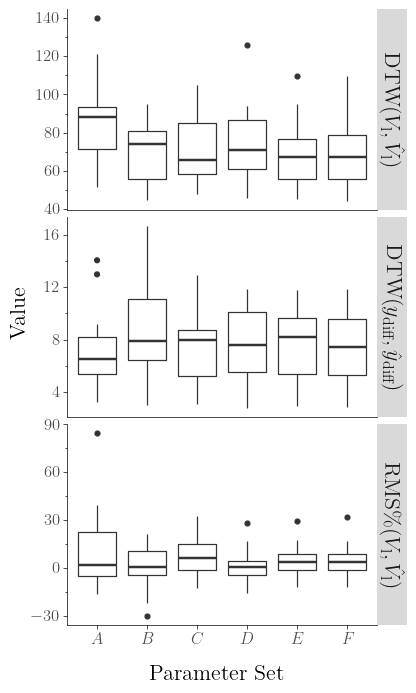

<ggplot: (8755170013209)>

In [130]:
lblr = labeller(rows=lambda y: cols_rename[y])

p = ggplot(aes(x='metric.name', y='value'), df_filtered_scores_melt)
p = (
    p
    + geom_boxplot()
    + facet_grid('variable ~ .', scales='free_y', labeller=lblr)
    + phd_theme()
    + theme(figure_size=(4, 8))
    + xlab('Parameter Set')
    + ylab('Value')
)
p.save('/home/michael/Nextcloud/PhD/LaTeX/Journal2/img/metric_density.pdf', dpi=200)
p

In [71]:
df2_filtered.query('model_id == 1342')

,grid_cell_id,model_id,y_diff_dtw_distance,rms_perc_diff,emf_dtw_distance,damper.damping_coefficient,coupling_model.coupling_constant,mechanical_spring.damping_coefficient,coil_model.coil_resistance,load_model.R,...,device_id,rms_perc_abs,dtw_mech,dtw_mech_norm,dtw_elec,dtw_elec_norm,dtw_both,rms_perc_abs_norm,rms_dtw_elec,balanced
1240,22.0,1342,10.843692,4.036338,56.299101,8.785714,5.0,10.0,12.5,30,...,A,4.036338,10.843692,0.099052,56.299101,0.010942,0.109994,0.006612,0.017553,0.116605
3802,22.0,1342,9.591694,8.964384,72.768044,8.785714,5.0,10.0,12.5,30,...,A,8.964384,9.591694,0.083889,72.768044,0.020165,0.104054,0.014687,0.034853,0.118741
8854,22.0,1342,9.572577,16.812416,58.628345,8.785714,5.0,10.0,12.5,30,...,A,16.812416,9.572577,0.083657,58.628345,0.012246,0.095903,0.027549,0.039795,0.123452
13306,22.0,1342,11.661677,-3.361827,67.326912,8.785714,5.0,10.0,12.5,30,...,A,3.361827,11.661677,0.108959,67.326912,0.017118,0.126076,0.005506,0.022624,0.131582
15484,22.0,1342,11.879617,2.989415,72.342826,8.785714,5.0,10.0,12.5,30,...,A,2.989415,11.879617,0.111598,72.342826,0.019927,0.131525,0.004896,0.024823,0.136421
15772,22.0,1342,8.395595,16.767749,95.212217,8.785714,5.0,10.0,23.5,30,...,B,16.767749,8.395595,0.069403,95.212217,0.032735,0.102138,0.027475,0.060210,0.129613
18166,22.0,1342,5.245508,3.660022,63.502392,8.785714,5.0,10.0,23.5,30,...,B,3.660022,5.245508,0.031252,63.502392,0.014976,0.046228,0.005995,0.020971,0.052223
22546,22.0,1342,7.398842,32.184830,77.033941,8.785714,5.0,10.0,23.5,30,...,B,32.184830,7.398842,0.057331,77.033941,0.022554,0.079885,0.052740,0.075294,0.132626
25156,22.0,1342,6.852640,8.727291,91.298617,8.785714,5.0,10.0,23.5,30,...,B,8.727291,6.852640,0.050716,91.298617,0.030543,0.081259,0.014299,0.044842,0.095558
27286,22.0,1342,5.415639,-1.082928,109.502622,8.785714,5.0,10.0,23.5,30,...,B,1.082928,5.415639,0.033313,109.502622,0.040738,0.074051,0.001772,0.042510,0.075822


In [72]:
import dask.dataframe as dd
from dask.distributed import Client
Client()

/home/michael/miniconda3/envs/ds/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45287 instead


Client Scheduler: tcp://127.0.0.1:43415 Dashboard: http://127.0.0.1:45287/status,Cluster Workers: 6 Cores: 24 Memory: 33.64 GB


In [73]:
# Ok, let's try load the groundtruth
# Let's get some groundtruth in here
from unified_model import evaluate
from unified_model import metrics
from unified_model.utils.utils import collect_samples
from scipy.signal import savgol_filter

from dataclasses import dataclass
from typing import Any


class GroundTruthFactory:
    def __init__(self, samples_list, lvp_kwargs, adc_kwargs):
        self.samples_list = samples_list
        self.lvp_kwargs = lvp_kwargs
        self.adc_kwargs = adc_kwargs
        
        @dataclass
        class MechanicalGroundtruth:
            y_diff: Any
            time: Any
        
        @dataclass
        class ElectricalGroundtruth:
            emf: Any
            time: Any
        
        @dataclass
        class Groundtruth:
            mech: MechanicalGroundtruth
            elec: ElectricalGroundtruth

        self.lvp = evaluate.LabeledVideoProcessor(**lvp_kwargs)
        self.adc = evaluate.AdcProcessor(**adc_kwargs)
        self.MechGroundtruth = MechanicalGroundtruth
        self.ElecGroundtruth = ElectricalGroundtruth
        self.Groundtruth = Groundtruth

    def _make_mechanical_groundtruth(self, sample):
        y_target, y_time_target = self.lvp.fit_transform(
            sample.video_labels_df,
            impute_missing_values=True
        )
        y_target = savgol_filter(y_target, 9, 3)

        return self.MechGroundtruth(y_target,
                                    y_time_target)

    def _make_electrical_groundtruth(self, sample):
        emf_target, emf_time_target = self.adc.fit_transform(sample.adc_df)
        return self.ElecGroundtruth(emf_target,
                                    emf_time_target)

    def make(self):
        groundtruths = []
        for sample in self.samples_list:
            mech_groundtruth = self._make_mechanical_groundtruth(sample)
            elec_groundtruth = self._make_electrical_groundtruth(sample)

            groundtruths.append(
                self.Groundtruth(mech_groundtruth, elec_groundtruth)
            )

        return groundtruths

# Prepare data
base_groundtruth_path = '../data/2019-05-23_D/'
samples = {}
samples['A'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='A/*acc*.csv',
                               adc_pattern='A/*adc*.csv',
                               video_label_pattern='A/*labels*.csv')
samples['B'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='B/*acc*.csv',
                               adc_pattern='B/*adc*.csv',
                               video_label_pattern='B/*labels*.csv')
samples['C'] = collect_samples(base_path=base_groundtruth_path,
                               acc_pattern='C/*acc*.csv',
                               adc_pattern='C/*adc*.csv',
                               video_label_pattern='C/*labels*.csv')



In [74]:
# Groundtruth

groundtruth = {}
for device in ['A', 'B', 'C']:
    groundtruth_factory = GroundTruthFactory(samples_list=samples[device][:],
                                             lvp_kwargs=dict(mm=10,
                                                             seconds_per_frame=1/60,
                                                             pixel_scale=0.154508),
                                             adc_kwargs=dict(voltage_division_ratio=1 / 0.342)  # noqa
    )
    groundtruth[device] = groundtruth_factory.make()

In [75]:
# Let's look at some examples from each

In [76]:
import dask.dataframe as dd 

def get_curve(df_curves_path, model_id, input_excitation_number, device_id):
    #df_curves = vaex.open(df_curves_path)[['model_id', 'input_excitation_number', 'device_id', 'time', 'emf', 'y_diff']]
    df_curves = dd.read_parquet(df_curves_path,
                                columns=['model_id', 'input_excitation', 'device_id', 'time', 'emf', 'y_diff'],
                                filters=[('device_id', '==', device_id), ('input_excitation', '==', input_excitation_number)])
    df_temp = df_curves[df_curves['model_id'] == model_id]
    df_temp = df_temp[df_temp['input_excitation'] == input_excitation_number]
    df_temp = df_temp[df_temp['device_id'] == device_id].compute()
    return df_temp.sort_values(by='time')

In [77]:
def compare_mech(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    
    mech_eval = evaluate.MechanicalSystemEvaluator(
        y_target = groundtruth[device_id][input_excitation_number].mech.y_diff,  # Referenced to zero
        time_target = groundtruth[device_id][input_excitation_number].mech.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance}
    )

    mech_eval.fit(
        y_predict = x['y_diff'].values,
        time_predict = x['time'].values
    )
    print(mech_eval.score())
    mech_eval.poof(figsize=(16,8))
    del x

In [78]:
def compare_elec(df_curves_path, groundtruth, model_id, input_excitation_number, device_id):
    x = get_curve(df_curves_path, model_id, input_excitation_number, device_id)
    
    elec_eval = evaluate.ElectricalSystemEvaluator(
        emf_target=groundtruth[device_id][input_excitation_number].elec.emf,  # Referenced to zero
        time_target=groundtruth[device_id][input_excitation_number].elec.time,
        metrics = {'dtw_distance': metrics.dtw_euclid_distance,
                  'rms_perc_diff': metrics.root_mean_square_percentage_diff}
    )
    
    elec_eval.fit(
        emf_predict=x['emf'].values,
        time_predict=x['time'].values
    )
    print(elec_eval.score())
    elec_eval.poof(figsize=(16, 8))
    del x
    return elec_eval

In [79]:
from scipy import signal

{'dtw_distance': 11.685597846456618}


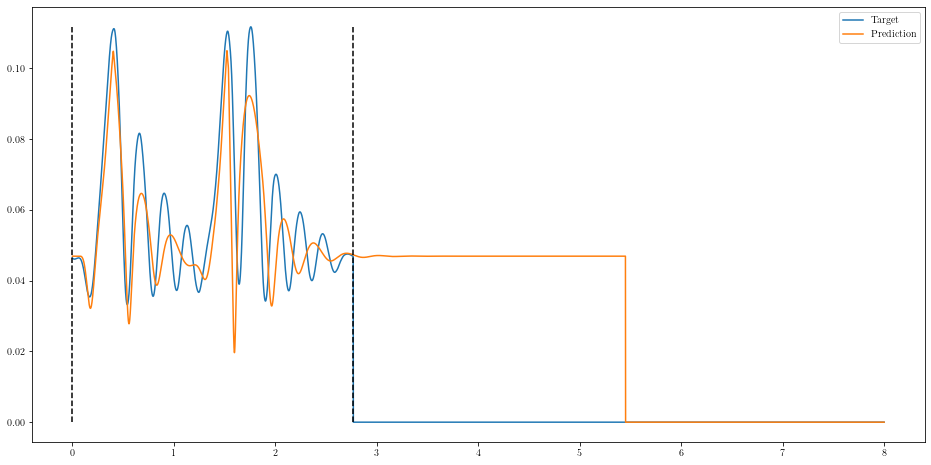

{'dtw_distance': 67.78952780404572, 'rms_perc_diff': -3.8173911521388764}


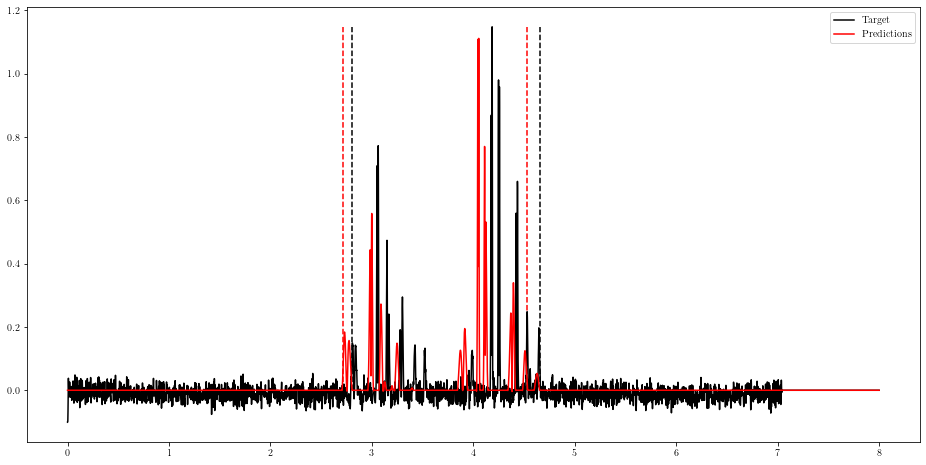

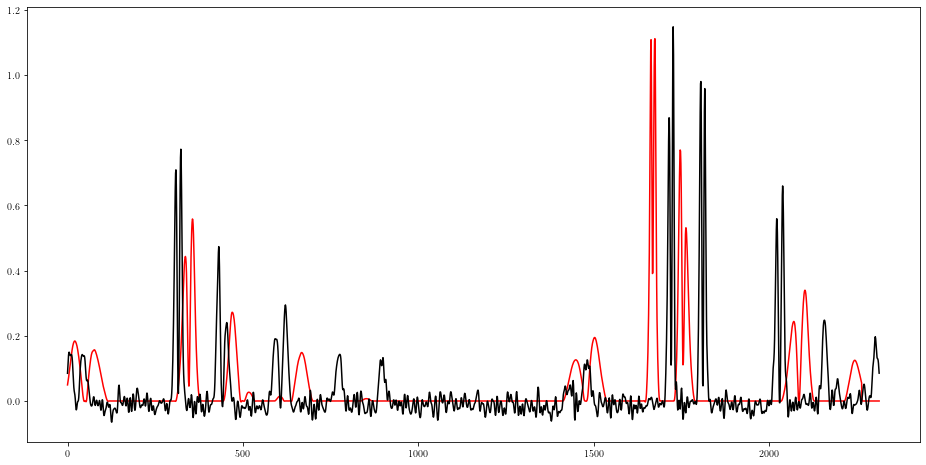

In [95]:
input_ = 5
device = 'A'
chosen_model_id = 1342

compare_mech('joined.parquet', groundtruth, chosen_model_id, input_, device)
ee = compare_elec('joined.parquet', groundtruth, chosen_model_id, input_, device)

plt.figure(figsize=(16, 8))
plt.plot(ee.emf_predict_clipped_, 'r')
plt.plot(ee.emf_target_clipped_, 'k')

In [56]:
emf_target_clipped_ = ee.emf_target_clipped_
emf_predict_clipped_ = ee.emf_predict_clipped_
clip_indexes = ee._clip_indexes

## Correlation investigation

In [49]:
df_sample = get_curve('joined.parquet', 661, 0, 'A')

In [50]:
g = groundtruth['A'][0]

In [51]:
pred_time = df_sample['time'].values
pred_emf = df_sample['emf'].values

truth_time = g.elec.time
truth_emf = g.elec.emf

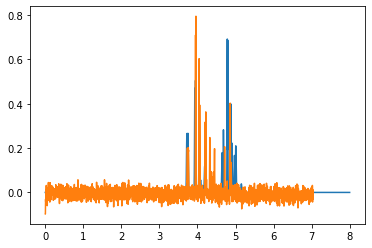

In [52]:
import matplotlib.pyplot as plt
plt.plot(pred_time, pred_emf)
plt.plot(truth_time, truth_emf)

In [56]:
# Start experiment
from scipy import signal
import numpy as np

# sampling periods
sampling_period_pred_time = np.mean(np.gradient(pred_time))
sampling_period_truth_time = np.mean(np.gradient(truth_time))

# Figure out up/down sampling ratio
ratio = sampling_period_pred_time/sampling_period_truth_time
ratio = np.round(ratio, 3)
up = ratio*1e3
down = 1e3

# We need to do a resampling period first
pred_emf_scaled = signal.resample_poly(pred_emf, up, down)

In [57]:
print(ratio)

4.799


In [58]:
pred_time_scaled = np.arange(0., max(pred_time), sampling_period_pred_time/ratio)
pred_time_scaled

array([0.00000000e+00, 6.24953721e-04, 1.24990744e-03, ...,
       7.99753277e+00, 7.99815772e+00, 7.99878268e+00])

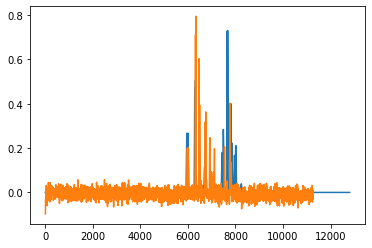

In [59]:
plt.plot(pred_emf_scaled)
plt.plot(truth_emf)

12800
12804


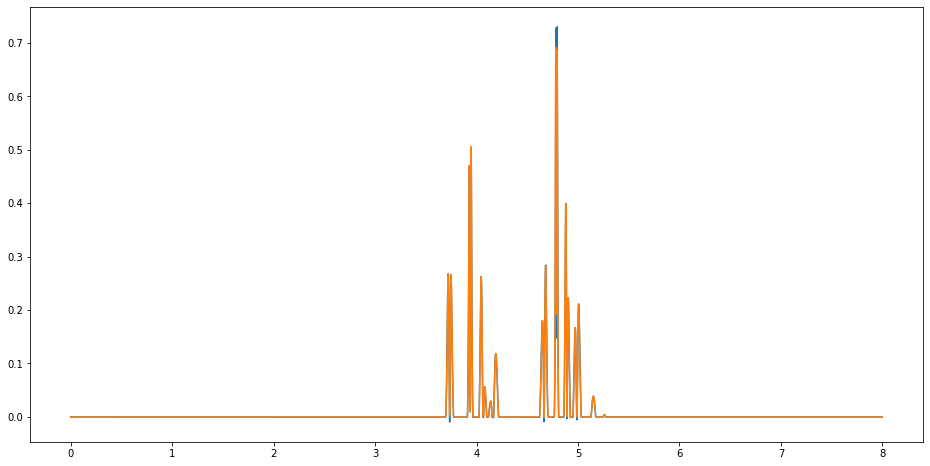

In [61]:
print(len(pred_time_scaled))
print(len(pred_emf_scaled))

# Just make sure any odd samples get clipped
pred_emf_scaled = pred_emf_scaled[:len(pred_time_scaled)]
pred_time_scaled = pred_time_scaled[:len(pred_emf_scaled)]

# Plot
plt.figure(figsize=(16, 8))
plt.plot(pred_time_scaled, pred_emf_scaled)
plt.plot(pred_time, pred_emf)

In [62]:
# Now that we've resampled, we can do correlation
corr_12 = signal.correlate(pred_emf_scaled, truth_emf)
corr_21 = signal.correlate(truth_emf, pred_emf_scaled)

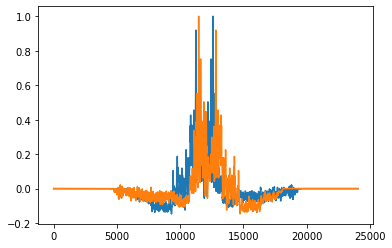

In [63]:
plt.plot(corr_12/max(corr_12))
plt.plot(corr_21/max(corr_21))

In [64]:
first_pos = np.argmax(corr_12)
second_pos = np.argmax(corr_21)

print(first_pos)
print(second_pos)

12599
11463


In [65]:
difference = first_pos - second_pos
difference

1136

In [68]:
if difference < 0:
    padded_pred = np.pad(pred_emf_scaled, (abs(difference), 0), 'constant')
if difference > 0:
    padded_pred = np.pad(pred_emf_scaled, (0, abs(difference)), 'constant')

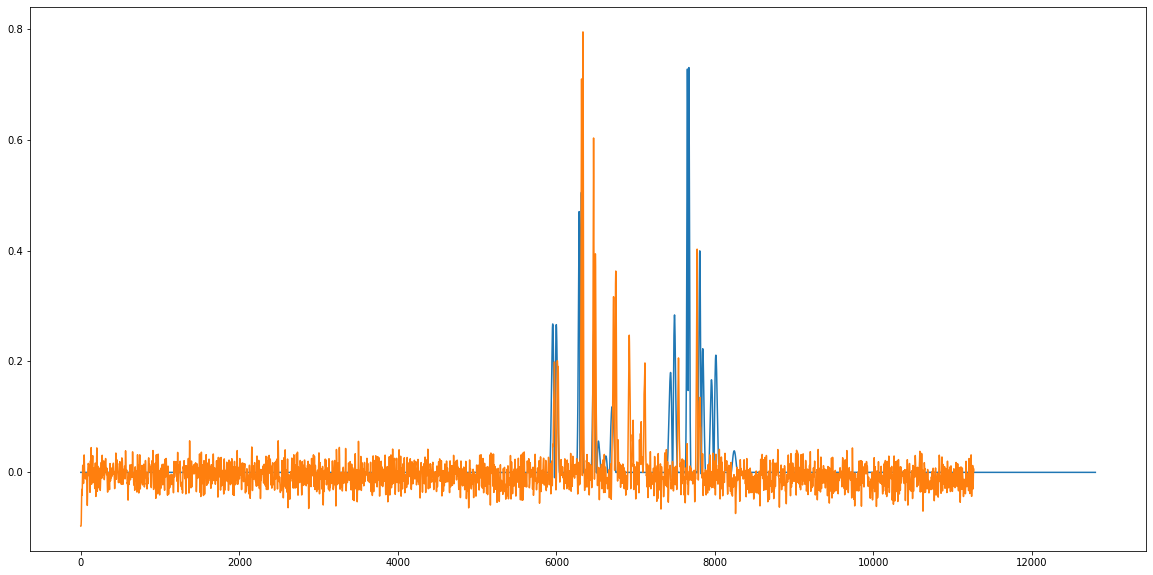

In [69]:
plt.figure(figsize=(20, 10))
plt.plot(pred_emf_scaled)
plt.plot(truth_emf)

In [70]:
from unified_model.utils.utils import find_signal_limits

In [71]:
# Another technique

start_truth, end_truth = find_signal_limits(truth_emf, 0.075)
start_pred, end_pred = find_signal_limits(pred_emf_scaled, 0.05)

In [72]:
start_pred - start_truth

-36

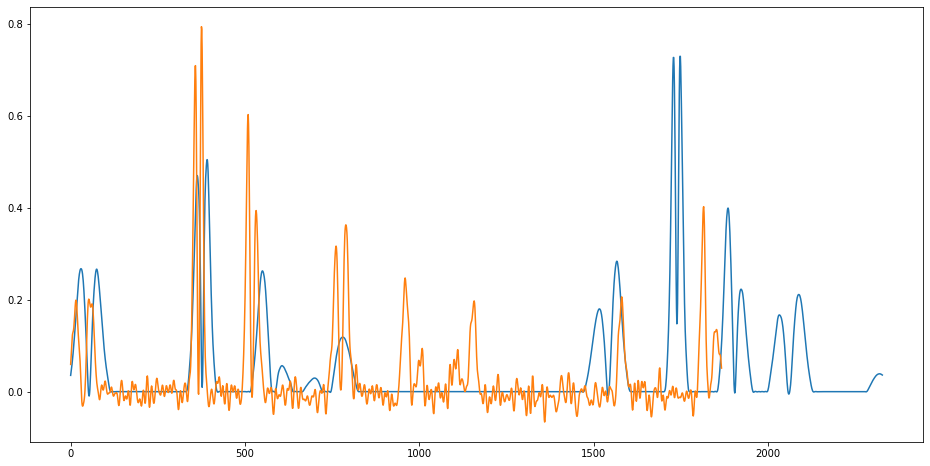

In [74]:
plt.figure(figsize=(16, 8))
plt.plot(pred_emf_scaled[start_pred:end_pred])
plt.plot(truth_emf[start_truth:end_truth])